In [1]:
import pandas as pd
from datetime import datetime
from zoe import find_latest, read_pickle, latest_map_data, find_previous, plot_study, plot_study_evolution

In [2]:
path, dt = find_latest('zoe_uk_active_cases_*.pickle', date_index=-2)
curr_date = pd.to_datetime(dt)
uk_active_cases = read_pickle(path)
print(path)
display(uk_active_cases)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-07-24_2021-07-24-18-00.pickle


,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,83380,None,None,61298.954008
2020-06-13,83381,None,None,58135.335871
2020-06-14,83382,None,None,55037.980828
2020-06-15,83383,None,None,52279.648025
2020-06-16,83384,None,None,49809.751428
...,...,...,...,...
2021-07-20,83783,None,None,667634.035745
2021-07-21,83784,None,None,691253.006669
2021-07-22,83785,None,None,712571.840685


In [3]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-07-23_2021-07-23-18-02.pickle


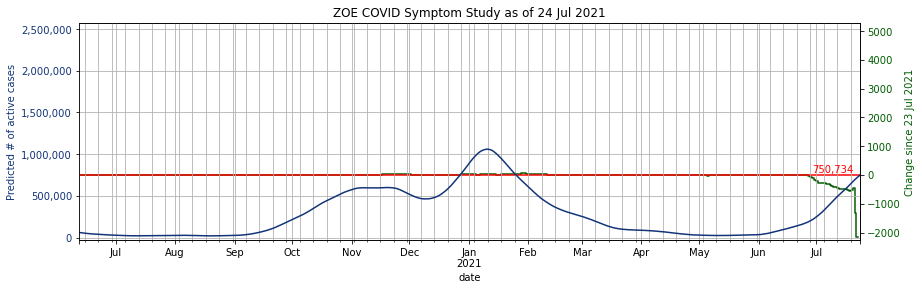

In [4]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

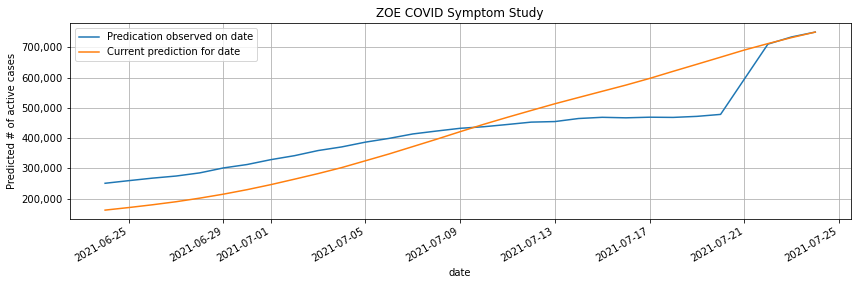

In [5]:
plot_study_evolution(curr_date, days=30)

In [6]:
for_date, prevalence_map = latest_map_data()
f'{for_date:%a %d %b %Y}'

'Sat 24 Jul 2021'

In [7]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
3,Stockton-on-Tees,E06000004,4.859405
60,Thurrock,E06000034,2.916746
342,Bridgend,W06000013,2.825156
279,Barnsley,E08000016,2.753820
346,Hackney,E09000012,2.498730
231,Wyre Forest,E07000239,2.467379
379,Tower Hamlets,E09000030,2.390915
203,Scarborough,E07000168,2.361330
361,Lambeth,E09000022,2.361028
15,"Kingston upon Hull, City of",E06000010,2.330216
